# General DA fittings and Fokker-Planck comparisons


## Setup scripts if we are under SWAN

In [ ]:
# Working in the right path
%cd /eos/project/d/da-and-diffusion-studies/DA_Studies/Simulations/Models/da_sixtrack

In [ ]:
# Install the libraries
import sys
!{sys.executable} -m pip install --user tqdm pynverse sixtrackwrap crank_nicolson_numba
!export PYTHONPATH=$CERNBOX_HOME/.local/lib/python3.7/site-packages:$PYTHONPATH

In [ ]:
# For this "presentation" only!
import warnings
warnings.filterwarnings('ignore')

## Imports

In [1]:
%matplotlib widget

In [1]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from scipy.special import erf
import pickle
import itertools
from scipy.optimize import curve_fit

from numba import njit, prange

# Personal libraries
#import sixtrackwrap_light as sx
import sixtrackwrap as sx

from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from math import gcd

import pandas as pd

from scipy.special import lambertw
from scipy.interpolate import interp1d

import warnings

## Load data and setup original DA

In [2]:
savepath = "data/"
raw_engine = sx.radial_scanner.load_values(savepath + "big_scan.pkl")
engine = sx.uniform_radial_scanner.load_values(savepath + "big_scan.pkl")

min_turns = engine.min_time
max_turns = engine.max_time
n_turn_samples = 500

turn_sampling = np.linspace(min_turns, max_turns, n_turn_samples, dtype=np.int_)[::-1]

d_r = engine.dr
starting_step = engine.starting_step

# BASELINE COMPUTING
baseline_samples = 33
baseline_total_samples = baseline_samples ** 3

In [3]:
alpha_preliminary_values = np.linspace(-1.0, 1.0, baseline_samples)
alpha_values = np.arccos(alpha_preliminary_values) / 2
theta1_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)
theta2_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)

d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]
d_theta1 = theta1_values[1] - theta1_values[0]
d_theta2 = theta2_values[1] - theta2_values[0]

alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

alpha_flat = alpha_mesh.flatten()
theta1_flat = theta1_mesh.flatten()
theta2_flat = theta2_mesh.flatten()

In [4]:
radiuses = raw_engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

In [5]:
DA = []

mod_radiuses = radiuses.copy()
mod_radiuses = np.power(radiuses, 4)
mod_radiuses1 = integrate.simps(mod_radiuses, x=theta1_values, axis=1)
mod_radiuses2 = integrate.simps(mod_radiuses1, x=theta2_values, axis=1)
mod_radiuses3 = integrate.simps(mod_radiuses2, x=alpha_preliminary_values, axis=0)

for i in range(len(turn_sampling)):
    DA.append(
        np.power(
            mod_radiuses3[i] / (2 * theta1_values[-1] * theta2_values[-1]),
            1/4
        )
    )

DA = np.asarray(DA)

In [6]:
axis_sampling = np.concatenate((turn_sampling,[0.0]))

## Prepare inverse functions for obtaining DA from loss values

In [7]:
from pynverse import inversefunc

# Uniform 4D distribution

@njit
def uniform_loss(DA, DA0):
    return (DA ** 4 / DA0 ** 4)

@njit
def DA_from_unifom_loss(loss, DA0):
    return np.power((loss * DA0 ** 4), 1/4)

# Symmetric 4D gaussian

@njit
def symmetric_gaussian_loss(DA, sigma, DA0):
    baseline = - np.exp(- 0.5 * (DA0 / sigma) ** 2) * (DA0 ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
    return (- np.exp(- 0.5 * (DA / sigma) ** 2) * (DA ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2) / baseline


def DA_from_symmetric_gaussian_loss(loss, sigma, DA0):
    func = inversefunc(
        lambda x: symmetric_gaussian_loss(x, sigma, DA0),
        domain=[0.0, DA0]
    )
    return func(loss)
    

## Define Fitting Models!

### $\chi^2$ function

In [8]:
def chi_2(original, estimate):
    return np.sum(np.power(estimate - original, 2) / original)

### Model 2

$$D(N) = \rho_\ast \left(\frac{\kappa}{2e}\right)^\kappa \frac{1}{\ln^\kappa\frac{N}{N_0}}$$


In [9]:
@njit
def model_2(x, rho, n0, k):
    return rho * np.power(k / (2 * np.exp(1)), k) / (np.power(np.log(x / n0), k))


def explore_k_model_2(turns, da, k_min, k_max, n_samples):
    ks = np.linspace(k_min, k_max, n_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a, b : model_2(x, a, b, k),
            turns,
            da,
            bounds=([0, 0.00001],[np.inf, turns[-1]-0.0001])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(chi_2(DA, model_2(turn_sampling, par[0], par[1], k)))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

### Model 4

$$D(N)=\rho_{*} \times \frac{1}{\left[-2 \mathrm{e} \lambda \mathcal{W}_{-1}\left(-\frac{1}{2 \mathrm{e} \lambda}\left(\frac{\rho_{\ast}}{6}\right)^{1 / \kappa}\left(\frac{8}{7} N\right)^{-1 /(\lambda \kappa)}\right)\right]^{\kappa}}
$$

(with $\lambda=0.5$)

In [10]:
def model_4(x, rho, k):
    lamb = 0.5
    return np.real(
        rho
        / np.power(-2 * np.exp(1) * lamb * lambertw(- (1 / (2 * np.exp(1) * lamb)) * np.power(rho / 6, 1 / k) * np.power((8/7) * x, -1 / (lamb * k)), -1), k)
    )

def explore_k_model_4(turns, da, k_min, k_max, n_samples):
    ks = np.linspace(k_min, k_max, n_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a : model_4(x, a, k),
            turns,
            da,
            bounds=([0.1],[np.inf])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(chi_2(DA, model_4(turn_sampling, par[0], k)))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

### A more free Model 4

$$D(N)=\rho_{*} \times \frac{1}{\left[-2 \mathrm{e} \lambda \mathcal{W}_{-1}\left(-\frac{1}{\lambda\kappa}\left(\frac{N}{N_0}\right)^{-\frac{1}{\lambda\kappa}}\right)\right]^{\kappa}}
$$

(with $\lambda=0.5$)

In [11]:
def model_4_free(x, rho, n0, k):
    lamb = 0.5
    temp = (
        rho / (np.power(- 2 * lamb * np.exp(1) * lambertw(- (1 / (lamb * k)) * np.power(x / n0, - 1 / (lamb * k)), -1), k))
    )
    
    return np.real(temp) # TODO: FIX IT WITH PROPER MATH!!!


def explore_model_4_free(turns, da, k_min, k_max, k_samples):
    ks = np.linspace(k_min, k_max, k_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a, b : model_4_free(x, a, b, k),
            turns,
            da,
            bounds=([0.01, 0.01], [np.inf, turns[-1] - 0.1])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(chi_2(DA, model_4_free(turn_sampling, par[0], par[1], k)))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

## Visualize original DA value from data

Text(0, 0.5, '$DA(N)$')

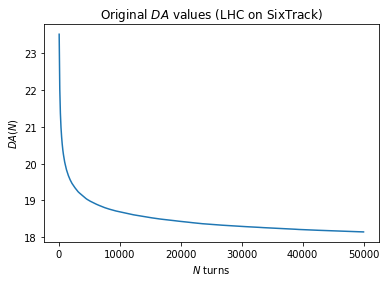

In [12]:
fig1, ax1 = plt.subplots()
ax1.plot(turn_sampling, DA)
ax1.set_title("Original $DA$ values (LHC on SixTrack)")
ax1.set_xlabel("$N$ turns")
ax1.set_ylabel("$DA(N)$")

## Setup Dataframe for storing the fitting data properly!

In [13]:
labels = (
    ("type", ""),
    ("sigma", ""),
    ("Model 2", "k"),
    ("Model 2", "k err"),
    ("Model 2", "rho"),
    ("Model 2", "rho err"),
    ("Model 2", "N0"),
    ("Model 2", "N0 err"),
    ("Model 2", "Chi2"),
    ("Model 4 (2 free pars)", "k"),
    ("Model 4 (2 free pars)", "k err"),
    ("Model 4 (2 free pars)", "rho"),
    ("Model 4 (2 free pars)", "rho err"),
    ("Model 4 (2 free pars)", "lambda"),
    ("Model 4 (2 free pars)", "Chi2"),
    ("Model 4 (3 free pars)", "k"),
    ("Model 4 (3 free pars)", "k err"),
    ("Model 4 (3 free pars)", "rho"),
    ("Model 4 (3 free pars)", "rho err"),
    ("Model 4 (3 free pars)", "N0"),
    ("Model 4 (3 free pars)", "N0 err"),
    ("Model 4 (3 free pars)", "lambda"),
    ("Model 4 (3 free pars)", "Chi2"),
)

fitting_data = pd.DataFrame(columns=pd.MultiIndex.from_tuples(labels))

## How is the error on the DA loss computed right now?

1. Consider all the radiuses sampled.
2. Compute the DA value.
3. For every radius sampled, compute the difference from the DA value.
4. The absolute value of the average of all these differences is considered as error.

(I tried using the Standard Deviation of the radiuses distribution, but it ended up being 10% of the DA itself, so we "need" somehow a smaller error estimation)
## Loss and Fits -- Uniform Beam Distribution
### Loss comparison

In [14]:
# Set DA0 cutting point
DA0 = 26.0

# Assign uniform weights to engine and compute loss
engine.assign_weights(
    sx.assign_uniform_distribution()
)
real_values = engine.compute_loss(turn_sampling, DA0)
real_values = np.concatenate((real_values, [1.0]))

# Compute DA-based loss
values = uniform_loss(DA, DA0)
values = np.concatenate((values, [1.0]))

# Error computing
values1 = uniform_loss(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), DA0)
values1 = np.concatenate((values1, [1.0]))

values2 = uniform_loss(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), DA0)
values2 = np.concatenate((values2, [1.0]))

#### Visualize Loss comparison

Text(0.5, 1.0, 'Uniform beam (Cutting Point at $DA=26.0$)')

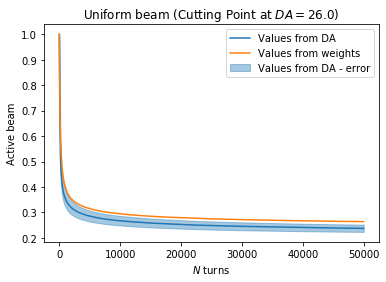

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(axis_sampling, values, label="Values from DA")
ax2.fill_between(axis_sampling, values1, values2, label="Values from DA - error", color="C0", alpha=0.4)
ax2.plot(axis_sampling, real_values, label="Values from weights")
ax2.legend()
ax2.set_xlabel("$N$ turns")
ax2.set_ylabel("Active beam")
ax2.set_title("Uniform beam (Cutting Point at $DA=26.0$)")

### Get DA from loss

In [16]:
DA_from_loss = DA_from_unifom_loss(real_values, DA0)

#### Visualize difference

Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss')

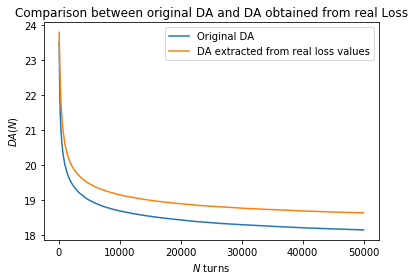

In [17]:
fig3, ax3 = plt.subplots()
ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss")

### Compare fitting values with Model 2

In [18]:
k_min = 0.05
k_max = 0.20
samples = 200

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_2(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_2(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_err_2 = np.min(real_errs)
real_selected_k_2 = ks[np.argmin(real_errs)]
real_selected_pars_2 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_2 = real_co_pars[np.argmin(real_errs)]

loss_selected_err_2 = np.min(loss_errs)
loss_selected_k_2 = ks[np.argmin(loss_errs)]
loss_selected_pars_2 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_2 = loss_co_pars[np.argmin(loss_errs)]

In [19]:
print("REAL:", "$\\kappa:$", real_selected_k_2, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_2)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_2, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_2)

REAL: $\kappa:$ 0.12010050251256282 , $\rho_\ast$ and $N_0$ [36.18640445 46.58671577]
FROM LOSS: $\kappa:$ 0.12386934673366835 , $\rho_\ast$ and $N_0$ [37.82745462 43.22660891]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss, with Model 2 Fits')

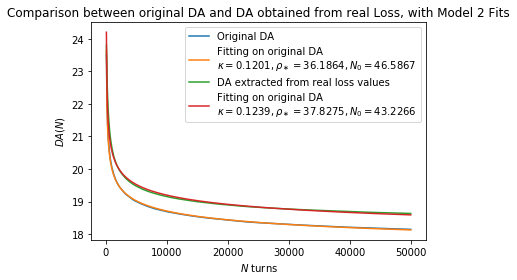

In [20]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_2(turn_sampling, real_selected_pars_2[0], real_selected_pars_2[1], real_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(real_selected_k_2, real_selected_pars_2[0], real_selected_pars_2[1] ))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_2(turn_sampling, loss_selected_pars_2[0], loss_selected_pars_2[1], loss_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(loss_selected_k_2, loss_selected_pars_2[0], loss_selected_pars_2[1] ))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss, with Model 2 Fits")

### Compare fitting values with Model 4

In [21]:
k_min = 0.15
k_max = 0.30
samples = 200

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_4(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_4(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_err_4 = np.min(real_errs)
real_selected_k_4 = ks[np.argmin(real_errs)]
real_selected_pars_4 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_4 = real_co_pars[np.argmin(real_errs)]

loss_selected_err_4 = np.min(loss_errs)
loss_selected_k_4 = ks[np.argmin(loss_errs)]
loss_selected_pars_4 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_4 = loss_co_pars[np.argmin(loss_errs)]

In [22]:
print("REAL:", "$\\kappa:$", real_selected_k_4, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_4)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_4, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_4)

REAL: $\kappa:$ 0.21633165829145728 , $\rho_\ast$ and $N_0$ [60.2736379]
FROM LOSS: $\kappa:$ 0.22236180904522612 , $\rho_\ast$ and $N_0$ [63.48946443]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss,\n with Model 4 Fits $(\\lambda=0.5)$, 2 free parameters')

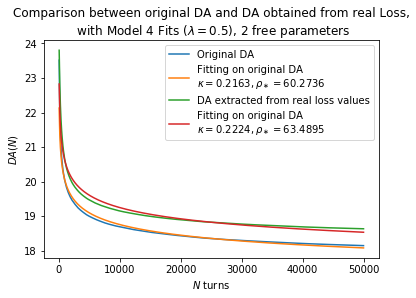

In [23]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_4(turn_sampling, real_selected_pars_4[0], real_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(real_selected_k_4, real_selected_pars_4[0]))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_4(turn_sampling, loss_selected_pars_4[0], loss_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(loss_selected_k_4, loss_selected_pars_4[0]))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss,\n with Model 4 Fits $(\\lambda=0.5)$, 2 free parameters")

### Compare fitting values with Model 4 (But more free)

In [24]:
k_min = 0.05
k_max = 0.20
samples = 200

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_model_4_free(turn_sampling[:], DA[:], k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_model_4_free(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_err_4_free = np.min(real_errs)
real_selected_k_4_free = ks[np.argmin(real_errs)]
real_selected_pars_4_free = real_pars[np.argmin(real_errs)]
real_selected_co_pars_4_free = real_co_pars[np.argmin(real_errs)]

loss_selected_err_4_free = np.min(loss_errs)
loss_selected_k_4_free = ks[np.argmin(loss_errs)]
loss_selected_pars_4_free = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_4_free = loss_co_pars[np.argmin(loss_errs)]

In [25]:
print("REAL:", "$\\kappa:$", real_selected_k_4_free, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_4_free)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_4_free, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_4_free)

REAL: $\kappa:$ 0.12311557788944724 , $\rho_\ast$ and $N_0$ [36.83247721 43.10890574]
FROM LOSS: $\kappa:$ 0.12688442211055279 , $\rho_\ast$ and $N_0$ [38.50590842 40.04295254]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss,\n with Model 4 Fits $(\\lambda=0.5)$, 3 free parameters')

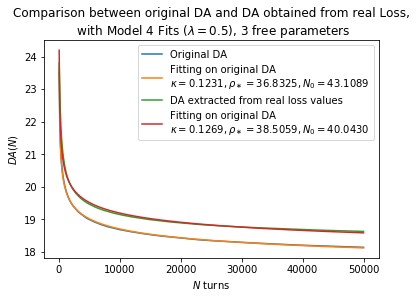

In [26]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_4_free(turn_sampling, real_selected_pars_4_free[0], real_selected_pars_4_free[1], real_selected_k_4_free), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0 = {:.4f}$".format(real_selected_k_4_free, real_selected_pars_4_free[0], real_selected_pars_4_free[1]))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_4_free(turn_sampling, loss_selected_pars_4_free[0], loss_selected_pars_4_free[1], loss_selected_k_4_free), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0 = {:.4f}$".format(loss_selected_k_4_free, loss_selected_pars_4_free[0], loss_selected_pars_4_free[1]))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss,\n with Model 4 Fits $(\\lambda=0.5)$, 3 free parameters")

### Save data in the dataframe

In [27]:
fitting_data.loc[len(fitting_data)] = [
     "real",
     np.nan,
     real_selected_k_2,
     ks[1] - ks[0],
     real_selected_pars_2[0],
     np.sqrt(real_selected_co_pars_2[0, 0]), 
     real_selected_pars_2[1], 
     np.sqrt(real_selected_co_pars_2[1, 1]), 
     real_selected_err_2,
     real_selected_k_4, 
     ks[1] - ks[0], 
     real_selected_pars_4[0], 
     np.sqrt(real_selected_co_pars_4[0, 0]),
     1/2,
     real_selected_err_4,
     real_selected_k_4_free, 
     ks[1] - ks[0], 
     real_selected_pars_4_free[0], 
     np.sqrt(real_selected_co_pars_4_free[0, 0]),
     real_selected_pars_4_free[1], 
     np.sqrt(real_selected_co_pars_4_free[1, 1]),
     1/2,
     real_selected_err_4_free
]


fitting_data.loc[len(fitting_data)] = [
    "uniform",
     np.nan,
     loss_selected_k_2,
     ks[1] - ks[0],
     loss_selected_pars_2[0],
     np.sqrt(loss_selected_co_pars_2[0, 0]),
     loss_selected_pars_2[1],
     np.sqrt(loss_selected_co_pars_2[1, 1]),
     loss_selected_err_2,
     loss_selected_k_4,
     ks[1] - ks[0],
     loss_selected_pars_4[0],
     np.sqrt(loss_selected_co_pars_4[0, 0]),
     1/2,
     loss_selected_err_4,
     loss_selected_k_4_free,
     ks[1] - ks[0],
     loss_selected_pars_4_free[0],
     np.sqrt(loss_selected_co_pars_4_free[0, 0]),
     loss_selected_pars_4_free[1],
     np.sqrt(loss_selected_co_pars_4_free[1, 1]),
     1/2,
     loss_selected_err_4_free
]

## Loss and Fits -- Symmetric Gaussian Beam Distribution
### Choose your Sigma!

In [28]:
sigma = 8.0

### Loss comparison

In [29]:
# Assign uniform weights to engine and compute loss
engine.assign_weights(
    sx.assign_symmetric_gaussian(sigma)
)
real_values = engine.compute_loss(turn_sampling, DA0)
real_values = np.concatenate((real_values, [1.0]))

# Compute DA-based loss
values = symmetric_gaussian_loss(DA, sigma, DA0)
values = np.concatenate((values, [1.0]))

# Error computing
values1 = symmetric_gaussian_loss(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), sigma, DA0)
values1 = np.concatenate((values1, [1.0]))

values2 = symmetric_gaussian_loss(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), sigma, DA0)
values2 = np.concatenate((values2, [1.0]))

#### Visualize Loss comparison

Text(0.5, 1.0, 'Symmetric Gaussian beam ($\\sigma=8.0$, Cutting Point at $DA=26.0$)')

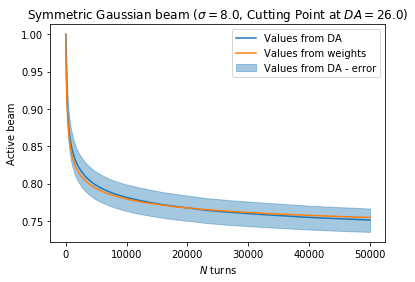

In [30]:
fig2, ax2 = plt.subplots()
ax2.plot(axis_sampling, values, label="Values from DA")
ax2.fill_between(axis_sampling, values1, values2, label="Values from DA - error", color="C0", alpha=0.4)
ax2.plot(axis_sampling, real_values, label="Values from weights")
ax2.legend()
ax2.set_xlabel("$N$ turns")
ax2.set_ylabel("Active beam")
ax2.set_title("Symmetric Gaussian beam ($\\sigma={}$, Cutting Point at $DA=26.0$)".format(sigma))

### Get DA from loss

In [31]:
DA_from_loss = DA_from_symmetric_gaussian_loss(real_values, sigma, DA0)

#### Visualize difference

Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss')

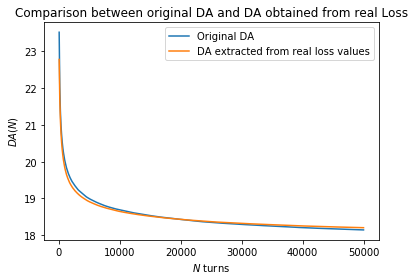

In [32]:
fig3, ax3 = plt.subplots()
ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss")

### Compare fitting values with Model 2

In [33]:
k_min = 0.05
k_max = 0.20
samples = 200

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_2(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_2(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_err_2 = np.min(real_errs)
real_selected_k_2 = ks[np.argmin(real_errs)]
real_selected_pars_2 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_2 = real_co_pars[np.argmin(real_errs)]

loss_selected_err_2 = np.min(loss_errs)
loss_selected_k_2 = ks[np.argmin(loss_errs)]
loss_selected_pars_2 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_2 = loss_co_pars[np.argmin(loss_errs)]

In [34]:
print("REAL:", "$\\kappa:$", real_selected_k_2, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_2)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_2, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_2)

REAL: $\kappa:$ 0.12010050251256282 , $\rho_\ast$ and $N_0$ [36.18640445 46.58671577]
FROM LOSS: $\kappa:$ 0.1163316582914573 , $\rho_\ast$ and $N_0$ [35.76944672 34.64271846]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss, with Model 2 Fits')

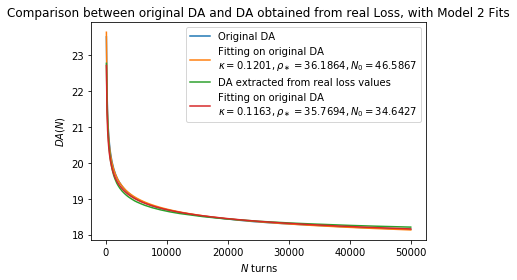

In [35]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_2(turn_sampling, real_selected_pars_2[0], real_selected_pars_2[1], real_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(real_selected_k_2, real_selected_pars_2[0], real_selected_pars_2[1] ))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_2(turn_sampling, loss_selected_pars_2[0], loss_selected_pars_2[1], loss_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(loss_selected_k_2, loss_selected_pars_2[0], loss_selected_pars_2[1] ))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss, with Model 2 Fits")

### Compare fitting values with Model 4

In [36]:
k_min = 0.15
k_max = 0.30
samples = 200

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_4(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_4(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_err_4 = np.min(real_errs)
real_selected_k_4 = ks[np.argmin(real_errs)]
real_selected_pars_4 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_4 = real_co_pars[np.argmin(real_errs)]

loss_selected_err_4 = np.min(loss_errs)
loss_selected_k_4 = ks[np.argmin(loss_errs)]
loss_selected_pars_4 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_4 = loss_co_pars[np.argmin(loss_errs)]

In [37]:
print("REAL:", "$\\kappa:$", real_selected_k_4, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_4)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_4, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_4)

REAL: $\kappa:$ 0.21633165829145728 , $\rho_\ast$ and $N_0$ [60.2736379]
FROM LOSS: $\kappa:$ 0.21633165829145728 , $\rho_\ast$ and $N_0$ [60.25543722]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss, with Model 4 Fits $(\\lambda=0.5)$')

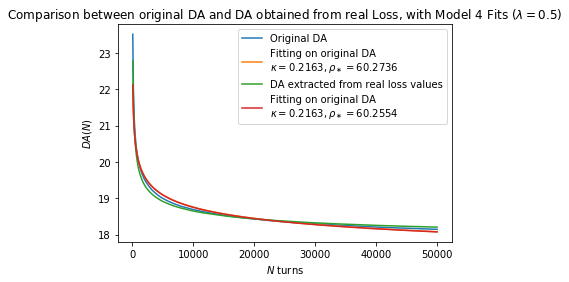

In [38]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_4(turn_sampling, real_selected_pars_4[0], real_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(real_selected_k_4, real_selected_pars_4[0]))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_4(turn_sampling, loss_selected_pars_4[0], loss_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(loss_selected_k_4, loss_selected_pars_4[0]))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss, with Model 4 Fits $(\\lambda=0.5)$")

### Compare fitting values with Model 4 (But more free)

In [39]:
k_min = 0.05
k_max = 0.20
samples = 200

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_model_4_free(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_model_4_free(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_err_4_free = np.min(real_errs)
real_selected_k_4_free = ks[np.argmin(real_errs)]
real_selected_pars_4_free = real_pars[np.argmin(real_errs)]
real_selected_co_pars_4_free = real_co_pars[np.argmin(real_errs)]

loss_selected_err_4_free = np.min(loss_errs)
loss_selected_k_4_free = ks[np.argmin(loss_errs)]
loss_selected_pars_4_free = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_4_free = loss_co_pars[np.argmin(loss_errs)]

In [40]:
print("REAL:", "$\\kappa:$", real_selected_k_4_free, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_4_free)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_4_free, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_4_free)

REAL: $\kappa:$ 0.12311557788944724 , $\rho_\ast$ and $N_0$ [36.83247721 43.10890574]
FROM LOSS: $\kappa:$ 0.11859296482412061 , $\rho_\ast$ and $N_0$ [36.2635254  32.68722542]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss,\n with Model 4 Fits $(\\lambda=0.5)$, 3 free parameters')

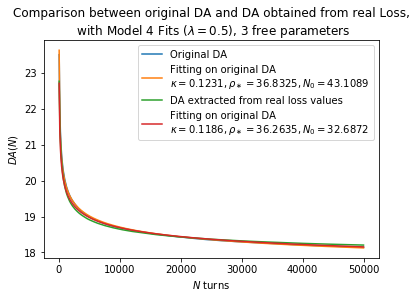

In [41]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_4_free(turn_sampling, real_selected_pars_4_free[0], real_selected_pars_4_free[1], real_selected_k_4_free), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0 = {:.4f}$".format(real_selected_k_4_free, real_selected_pars_4_free[0], real_selected_pars_4_free[1]))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_4_free(turn_sampling, loss_selected_pars_4_free[0], loss_selected_pars_4_free[1], loss_selected_k_4_free), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0 = {:.4f}$".format(loss_selected_k_4_free, loss_selected_pars_4_free[0], loss_selected_pars_4_free[1]))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss,\n with Model 4 Fits $(\\lambda=0.5)$, 3 free parameters")

### Save data in the dataframe

In [42]:
fitting_data.loc[len(fitting_data)] = [
    "gaussian",
     sigma,
     loss_selected_k_2,
     ks[1] - ks[0],
     loss_selected_pars_2[0],
     np.sqrt(loss_selected_co_pars_2[0, 0]),
     loss_selected_pars_2[1],
     np.sqrt(loss_selected_co_pars_2[1, 1]),
     loss_selected_err_2,
     loss_selected_k_4,
     ks[1] - ks[0],
     loss_selected_pars_4[0],
     np.sqrt(loss_selected_co_pars_4[0, 0]),
     1/2,
     loss_selected_err_4,
     loss_selected_k_4_free,
     ks[1] - ks[0],
     loss_selected_pars_4_free[1],
     np.sqrt(loss_selected_co_pars_4_free[1, 1]),
     loss_selected_pars_4_free[0],
     np.sqrt(loss_selected_co_pars_4_free[0, 0]),
     1/2,
     loss_selected_err_4_free
]


## Display general dataframe with fitting data

In [43]:
fitting_data[["type", "sigma", "Model 2"]]

type sigma   Model 2                                            \
                          k     k err        rho   rho err         N0   
0      real   NaN  0.120101  0.000754  36.186404  0.003748  46.586716   
1   uniform   NaN  0.123869  0.000754  37.827455  0.011225  43.226609   
2  gaussian   8.0  0.116332  0.000754  35.769447  0.009985  34.642718   

                       
     N0 err      Chi2  
0  0.202931  0.008032  
1  0.537353  6.197089  
2  0.463256  0.095802

In [44]:
fitting_data[["type", "sigma", "Model 4 (2 free pars)"]]

type sigma Model 4 (2 free pars)                                        \
                                      k     k err        rho   rho err lambda   
0      real   NaN              0.216332  0.000754  60.273638  0.012653    0.5   
1   uniform   NaN              0.222362  0.000754  63.489464  0.014782    0.5   
2  gaussian   8.0              0.216332  0.000754  60.255437  0.015353    0.5   

             
       Chi2  
0  0.180549  
1  6.378108  
2  0.181271

In [45]:
fitting_data[["type", "sigma", "Model 4 (3 free pars)"]]

type sigma Model 4 (3 free pars)                                 \
                                      k     k err        rho   rho err   
0      real   NaN              0.123116  0.000754  36.832477  0.003964   
1   uniform   NaN              0.126884  0.000754  38.505908  0.011560   
2  gaussian   8.0              0.118593  0.000754  32.687225  0.440157   

                                         
          N0    N0 err lambda      Chi2  
0  43.108906  0.194280    0.5  0.008783  
1  40.042953  0.502028    0.5  6.198017  
2  36.263525  0.010217    0.5  0.095951

# Fokker-Planck and Nekhoroshev

In [46]:
import crank_nicolson_numba.nekhoroshev as nk

In [47]:
k = fitting_data[("Model 4 (3 free pars)", "k")][0]
rho = fitting_data[("Model 4 (3 free pars)", "rho")][0]
N0 = fitting_data[("Model 4 (3 free pars)", "N0")][0]

## 4D normal distribution in 1D Action variable
If we consider the following distribution:

$$ f(x,p_x,y,p_y) = \frac{1}{4\pi^2\sigma^4}\exp\left[-\frac{1}{2}\left(\frac{x^2}{\sigma^2}+\frac{p_x^2}{\sigma^2}+\frac{y^2}{\sigma^2}+\frac{p_y^2}{\sigma^2}\right)\right]$$

we convert the distribution to polar variables:

$$f(r, \alpha, \theta_1, \theta_2) = \frac{r^3 \sin(\alpha)\cos(\alpha)}{4\pi^2\sigma^4} \exp\left[-\frac{1}{2}\left(\frac{r^2}{\sigma^2}\right)\right]$$

we then consider distribution integrated over $\alpha, \theta_1, \theta_2$:

$$f(r) = \int_0^{2\pi}\int_0^{2\pi}\int_0^{\pi/2} f(r,\alpha,\theta_1,\theta_2)\,d\alpha\,d\theta_1\,d\theta_2 = \frac{r^3}{2\sigma^4}\exp\left[-\frac{1}{2}\left(\frac{r^2}{\sigma^2}\right)\right]$$


and then we consider $I = r^2/2$ which implies also $dr = dI/I^{1/2}$, and end up with:

$$f(I) = \frac{I}{\sigma^4}\exp\left[-\frac{I}{\sigma^2}\right] = c I \exp\left[-\frac{I}{\sigma^2}\right]$$

where $c$ will be normalized in order to have a unitary starting value for the distributions considered.

## Nekhoroshev-like Diffusion equation

$$D(I) = c \exp\left[-\left(\frac{I_\ast}{I}\right)^{1/2\kappa}\right]$$

* Try to use free $\kappa$
* (done) Fix $\kappa$ 

### Parameters setup

In [48]:
I_max = DA0**2 / 2
I = np.linspace(0, I_max, 3000)
I0 = I * np.exp(-(I/sigma**2))
I0 /= integrate.trapz(I0, I)

c = 1.0

I_star_min = 150.0
I_star_max = 350.0
I_star_steps = 201
I_star_list = np.linspace(I_star_min, I_star_max, I_star_steps)

iter_step = 100

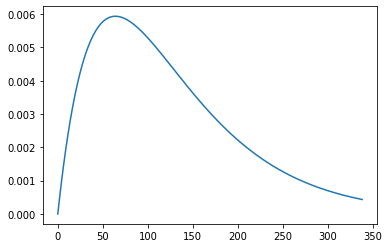

In [49]:
tfig, tax = plt.subplots()
tax.plot(I, I0)

In [50]:
data = []
errors = []
original_times = []

dt = 1.0
for j, I_star in tqdm(enumerate(I_star_list), total=I_star_steps):
    engine_nk = nk.cn_nekhoroshev(I_max, c, I_star, 1 / (k * 2), 0, I0, dt)
    i = 0
    
    t = []
    survival = []

    while(1.0 - engine_nk.get_particle_loss() >= values[0]):
        t.append(i * dt)
        survival.append(1.0 - engine_nk.get_particle_loss())
        engine_nk.iterate(iter_step)
        i += 1
    t.append(i * dt)
    survival.append(1.0 - engine_nk.get_particle_loss())

    print("Step:", j, "/", I_star_steps, ",", "Number of steps executed", i, ", dt:", dt)
    if i > 100:
        print("Increasing dt!")
        dt *= 10
        
    
    f = interp1d(t, survival, kind="cubic")
    inv_f = inversefunc(f, domain=(t[0], t[-1]))
    point_t = inv_f(values[0])
    points_t = np.linspace(0, point_t, len(axis_sampling))
    values_f = f(points_t)
    values_f = values_f[::-1]
    
    data.append(values_f)
    errors.append(chi_2(values, values_f))
    original_times.append(np.asarray(t)[::-1])
    if j > I_star_steps * 0.1:
        if(errors[-2] - errors[-1] < 0):
            print("Found minimum! Breaking!")
            break

Step: 0 / 201 , Number of steps executed 487 , dt: 1.0
Increasing dt!
Step: 1 / 201 , Number of steps executed 50 , dt: 10.0
Step: 2 / 201 , Number of steps executed 51 , dt: 10.0
Step: 3 / 201 , Number of steps executed 51 , dt: 10.0
Step: 4 / 201 , Number of steps executed 52 , dt: 10.0
Step: 5 / 201 , Number of steps executed 53 , dt: 10.0
Step: 6 / 201 , Number of steps executed 53 , dt: 10.0
Step: 7 / 201 , Number of steps executed 54 , dt: 10.0
Step: 8 / 201 , Number of steps executed 55 , dt: 10.0
Step: 9 / 201 , Number of steps executed 56 , dt: 10.0
Step: 10 / 201 , Number of steps executed 57 , dt: 10.0
Step: 11 / 201 , Number of steps executed 58 , dt: 10.0
Step: 12 / 201 , Number of steps executed 58 , dt: 10.0
Step: 13 / 201 , Number of steps executed 59 , dt: 10.0
Step: 14 / 201 , Number of steps executed 60 , dt: 10.0
Step: 15 / 201 , Number of steps executed 61 , dt: 10.0
Step: 16 / 201 , Number of steps executed 62 , dt: 10.0
Step: 17 / 201 , Number of steps executed 6

In [51]:
best_idx = np.argmin(errors)
best_data = data[best_idx]
best_time = original_times[best_idx]
best_I_star = I_star_list[best_idx]

In [52]:
print("Displaying the best FP values obtained:")
print("I_star = {}".format(best_I_star))
print("Time scale = {}".format(best_time[0]/axis_sampling[0]))

Displaying the best FP values obtained:
I_star = 237.0
Time scale = 1.88


Text(0.5, 1.0, 'Comparison between loss curve from DA\nand best equivalent Fokker-Planck process')

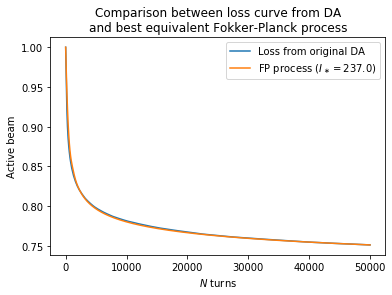

In [53]:
fp2_fig, fp2_ax = plt.subplots()
fp2_ax.plot(axis_sampling, values, label="Loss from original DA")
fp2_ax.plot(axis_sampling, best_data, label="FP process $(I_\\ast={})$".format(best_I_star))
fp2_ax.legend()
fp2_ax.set_xlabel("$N$ turns")
fp2_ax.set_ylabel("Active beam")
fp2_ax.set_title("Comparison between loss curve from DA\nand best equivalent Fokker-Planck process")

Text(0.5, 1.0, 'Error measured from the various FP loss comparisons performed')

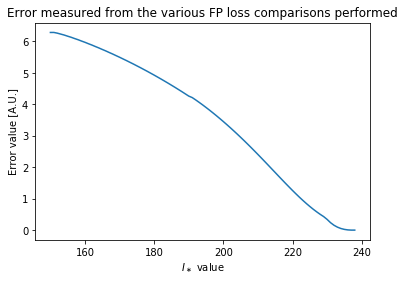

In [54]:
fp3_fig, fp3_ax = plt.subplots()
fp3_ax.plot(I_star_list[:len(errors)], errors)
fp3_ax.set_xlabel("$I_\\ast$ value")
fp3_ax.set_ylabel("Error value [A.U.]")
fp3_ax.set_title("Error measured from the various FP loss comparisons performed")

Text(0.5, 1.0, 'Explored $I_\\ast$ values')

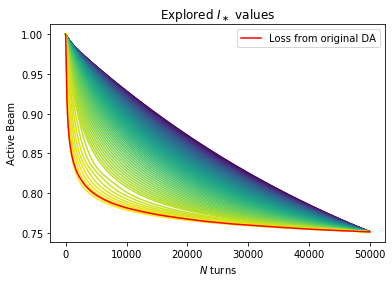

In [55]:
fp1_fig, fp1_ax = plt.subplots()
cmap = matplotlib.cm.get_cmap('viridis')
for i, d in enumerate(data):
    fp1_ax.plot(axis_sampling, d, c=cmap(i/(len(data)-1)))
fp1_ax.plot(axis_sampling, values, c="red", label="Loss from original DA")
fp1_ax.legend()
fp1_ax.set_xlabel("$N$ turns")
fp1_ax.set_ylabel("Active Beam")
fp1_ax.set_title("Explored $I_\\ast$ values")

# Testing distributions (now it's useless but I will keep it around for a bit)

In [46]:
engine.weights[0,0,0,:]

array([6.18415428e-06, 6.13602880e-06, 5.99388785e-06, 5.76426561e-06,
       5.45749699e-06, 5.08694655e-06, 4.66804455e-06, 4.21722681e-06,
       3.75087917e-06, 3.28437954e-06, 2.83131214e-06, 2.40290341e-06,
       2.00770094e-06, 1.65148975e-06, 1.33741716e-06, 1.06628192e-06,
       8.36934270e-07, 6.46732678e-07, 4.92008276e-07, 3.68497172e-07,
       2.71712776e-07, 1.97242323e-07, 1.40962731e-07, 9.91796684e-08,
       6.86997484e-08, 4.68491581e-08, 3.14530368e-08, 2.07891879e-08,
       1.35277826e-08, 8.66622284e-09, 5.46571823e-09, 3.39374163e-09,
       2.07455264e-09, 1.24848777e-09, 7.39704525e-10, 4.31465829e-10,
       2.47769980e-10, 1.40076446e-10])

In [48]:
temp_data = -integrate.trapz(
    integrate.trapz(
        integrate.trapz(
            engine.weights,
            x=engine.theta1_values,
            axis=2
        ),
        x=engine.theta2_values,
        axis=1
    ) * (np.sin(engine.alpha_values) * np.cos(engine.alpha_values))[:,None],
    x=engine.alpha_values,
    axis=0
)

temp_data /= integrate.trapz(temp_data, x=engine.r_values)
x = engine.r_values

plt.plot(
    x,
    temp_data
)
y = (1/(2 * sigma**4)) * np.exp(-0.5*(x**2 / sigma**2))
y /= np.trapz(y, x=x)
plt.plot(
    x,
    y
)

y2 = y * x ** 3

plt.plot(
    x,
    y2
)

In [49]:
-integrate.trapz(integrate.trapz(
    integrate.trapz(
        integrate.trapz(
            engine.weights,
            x=engine.theta1_values,
            axis=2
        ),
        x=engine.theta2_values,
        axis=1
    ) * (np.sin(engine.alpha_values) * np.cos(engine.alpha_values))[:,None],
    x=engine.alpha_values,
    axis=0
) * engine.r_values ** 3 * (engine.r_values < DA[0]), x=engine.r_values)

0.7014032844745755

In [50]:
tfig, taxs = plt.subplots()
new_r = np.power(engine.r_values, 2) / 2

-integrate.trapz(integrate.trapz(
    integrate.trapz(
        integrate.trapz(
            engine.weights,
            x=engine.theta1_values,
            axis=2
        ),
        x=engine.theta2_values,
        axis=1
    ) * (np.sin(engine.alpha_values) * np.cos(engine.alpha_values))[:,None],
    x=engine.alpha_values,
    axis=0
) * new_r * 2 * (engine.r_values < DA[0]), x=new_r)

plt.plot(new_r, -integrate.trapz(
    integrate.trapz(
        integrate.trapz(
            engine.weights,
            x=engine.theta1_values,
            axis=2
        ),
        x=engine.theta2_values,
        axis=1
    ) * (np.sin(engine.alpha_values) * np.cos(engine.alpha_values))[:,None],
    x=engine.alpha_values,
    axis=0
) * new_r * 2)

plt.plot(
    new_r,
    (new_r / sigma**4) * np.exp(-new_r / sigma**2)
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …